In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import warnings
import seaborn as sns
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [4]:
df_1 = pd.read_csv('data/ibes_2019.csv', index_col = [0]) # 157.932 rows
df_2 = pd.read_csv('data/crsp_daily_2019.csv', index_col = [0]) # 1.902.952 rows
df = pd.read_csv('data_after_1e.csv', index_col = [0]) # 121.326 rows

## 1. Basic data manipulation (25%)

#### a) Briefly describe the structure of the data. What is the smallest unit of observation?

In [5]:
df_1.describe()

,estimator,analys,value,actual,permno
count,157932.000000,157932.000000,157932.000000,157932.000000,157932.000000
mean,1229.519793,110569.194141,3.397169,3.423618,52751.972931
std,1317.160204,48965.960280,4.929264,5.221311,32979.683319
min,11.000000,0.000000,-9.880000,-13.630000,10026.000000
25%,171.000000,77712.000000,0.830000,0.860000,15642.000000
50%,464.000000,114862.500000,2.443000,2.450000,60943.000000
75%,2394.000000,147221.000000,4.870000,4.990000,86072.000000
max,4390.000000,193808.000000,28.860000,29.940000,93436.000000


#### b) Rename anndats_act as date, then merge (m:1) ibes_2019.dta to (using) crsp_daily 2019.dta. Keep only the observations that are successfully merged. Compute companies' market capitalization (mktcap).

In [6]:
df_1.rename(columns = {'anndats_act':'date'}, inplace = True)
df = pd.merge(df_1, df_2, on=['permno', 'date'], how='inner')
df['mktcap'] = df['shrout'] * df['prc']

In [8]:
def missing_statistics(df):
    '''
        Calculates missing value statistics for a given dataframe and
        returns a dataframe containing number of missing values per column
        and the percentage of values missing per column.
        arguments:
            df: the dataframe for which missing values need to be calculated.
    '''
    missing_stats = df.isnull().sum().to_frame()
    missing_stats.columns = ['num_missing']
    missing_stats['pct_missing'] = round(100 * (missing_stats['num_missing'] / df.shape[0]),2)
    missing_stats.sort_values(by='num_missing', ascending=False, inplace=True)

    return missing_stats

In [9]:
missing_statistics(df).T

,siccd,prc,mktcap,estimator,analys,value,anndats,actual,date,permno,shrout
num_missing,65.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pct_missing,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### c) Compute the consensus forecast (consensus), defined as the median forecast across analysists, and the standard deviation of the forecasts (dispersion). Then, compute the following two measures of forecast accuracy - fe and fd. 

In [10]:
# compute consensus
df_agg_consensus_median = df.groupby(['permno'])[['value']].median().reset_index()
assign_consensus_median_dic = pd.Series(df_agg_consensus_median.value.values, index = df_agg_consensus_median.permno).to_dict()
df["consensus"] = df["permno"].apply(lambda x: assign_consensus_median_dic.get(x))

# compute dispersion
df_agg_consensus_std = df.groupby(['permno'])[['value']].std().reset_index()
assign_consensus_std_dic = pd.Series(df_agg_consensus_std.value.values, index = df_agg_consensus_std.permno).to_dict()
df["dispersion"] = df["permno"].apply(lambda x: assign_consensus_std_dic.get(x))

# compute fe and fd
df['fe'] = (df['actual']-df['consensus'])/df['actual']
df['fe'] = df['fe'].abs()
df['fd'] = df['dispersion']/(df['actual'].abs())

#### d) Generate a variable coverage equal to the number of analysts providing a forecast for a given earnings announcement.

In [11]:
# making unique_id consisting of permno and analys + check for duplicates
df['unique_id'] = df['permno'].astype(str) + '_' + df['analys'].astype(str)
df_unique = df.drop_duplicates(subset='unique_id', keep="last")

# group them and convert in dictionary for mapping
df_agg = df_unique.groupby(['permno', 'date']).size().reset_index(name = 'counts')
df_agg_count = df_agg.groupby(['permno']).sum().reset_index()
assign_dic = pd.Series(df_agg_count.counts.values, index = df_agg_count.permno).to_dict()
df["coverage"] = df["permno"].apply(lambda x: assign_dic.get(x))

#### e) Drop the following industries from the dataset: international affairs and non-op. establishments (SIC 9000-9999), foreign governments (SIC 8888), utilities (SIC 4000-4999) and agricolture, fishing and hunting (SIC 0000-0999). Create a dummy variable financials for financial firms (SIC 6000-6999).

In [12]:
## drop all rows where siccd between 9000 and 9999
## dropped: 20.267 rows
op_labels = ['9000 and 9999']
category = [9000, 10000]
df['labels_1'] = pd.cut(df['siccd'], labels=op_labels, bins=category, include_lowest=False)
df = df.loc[~df['labels_1'].isin(op_labels)]

In [13]:
## drop all rows where siccd between 4000 and 4999
## dropped: 14.557 rows
op_labels = ['4000 and 4999']
category = [4000, 5000]
df['labels_2'] = pd.cut(df['siccd'], labels=op_labels, bins=category, include_lowest=False)
df = df.loc[~df['labels_2'].isin(op_labels)]

In [14]:
## drop all rows where siccd between 0 and 999
## dropped: 228 rows
labels_3 = []
for i in df['siccd']:
    between = range(0, 1000)
    if i in between:
        labels_3.append(1)
    else:
        labels_3.append(0)
df['labels_3'] = labels_3
df = df[df['labels_3'] == 0]

In [15]:
## drop all rows where siccd == 8888
## dropped: 0 rows
labels_4 = []
for i in df['siccd']:
    between = range(8888, 8889)
    if i in between:
        labels_4.append(1)
    else:
        labels_4.append(0)
df['labels_4'] = labels_4
df = df[df['labels_4'] == 0]

In [16]:
## make dummy_variable fiancials where financial firms == 1 and non-financial firms == 0
dummy_list = []
for i in df['siccd']:
    between = range(6000, 7000)
    if i in between:
        dummy_list.append(1)
    else:
        dummy_list.append(0)
df['financials'] = dummy_list

In [17]:
df = df[['estimator', 'analys', 'value', 'anndats', 'actual', 'date', 'permno', 
         'siccd', 'prc', 'shrout', 'mktcap', 'consensus', 'dispersion', 'fe',
         'fd', 'unique_id', 'coverage', 'financials']]

In [18]:
df.shape

(121326, 18)

## 2. Summary Statistics and Plots (30%)

#### a) How many distinct earnings announcements events are in the data?

In [19]:
distinct_earnings = df.groupby(['permno', 'date']).size().reset_index()
distinct_earnings_len = str(len(distinct_earnings['permno']))
print ('There are ' + distinct_earnings_len + ' distinct earnings announcements in the dataset.')

There are 2714 distinct earnings announcements in the dataset.


#### b) Collapse the data at earnings announcement level and keep the mean of fe, fd, coverage, mktcap, financials.

In [20]:
# compute mean-aggregation for mktcap, fe, fd and coverage
df_agg_01 = df.groupby(['permno'], as_index=True).agg({'mktcap': 'mean', 'fe': 'mean', 'fd': 'mean', 'coverage': 'mean'})

# compute mean-aggregation for financials
df_agg_02 = df.groupby('permno').agg({'financials': 'mean'}).reset_index()

# join df_agg_01 and df_agg_02 together
df_join = pd.merge(df_agg_01, df_agg_02, on = 'permno', how = 'inner')
df = df_join.copy()
df

,permno,mktcap,fe,fd,coverage,financials
0,10026.0,3.601009e+06,0.004000,0.023770,7,0
1,10032.0,1.909333e+06,0.040816,0.059723,7,0
2,10051.0,7.177990e+05,0.012821,0.065828,3,0
3,10104.0,1.800420e+08,0.035085,0.017733,37,0
4,10107.0,1.042658e+09,0.067368,0.027927,36,0
...,...,...,...,...,...,...
2709,93422.0,1.939154e+06,1.176471,0.971784,19,0
2710,93423.0,4.632071e+06,0.148607,0.052745,13,0
2711,93426.0,4.450518e+05,0.121951,0.134854,2,0
2712,93427.0,2.079591e+06,0.031496,0.044974,6,0


#### c) Produce a summary statistics table with the mean, standard deviation, min and max of all the variables in the dataset. Include also a correlation matrix between all the variables.

In [21]:
#print (df.describe().to_latex(float_format=lambda x: '%.2f' % x))
df.describe()

,permno,mktcap,fe,fd,coverage,financials
count,2714.000000,2.713000e+03,2714.000000,2673.000000,2714.000000,2714.000000
mean,58617.072218,9.916172e+06,0.194597,0.182542,10.075903,0.257553
std,32596.460766,4.296946e+07,0.311343,0.233502,8.834397,0.437367
min,10026.000000,-5.775145e+04,0.000000,0.000000,1.000000,0.000000
25%,16765.750000,4.042021e+05,0.027031,0.040797,4.000000,0.000000
50%,77386.000000,1.556870e+06,0.073751,0.097049,7.000000,0.000000
75%,87710.250000,5.488860e+06,0.222091,0.226816,14.000000,1.000000
max,93429.000000,1.080869e+09,2.875000,2.000000,57.000000,1.000000


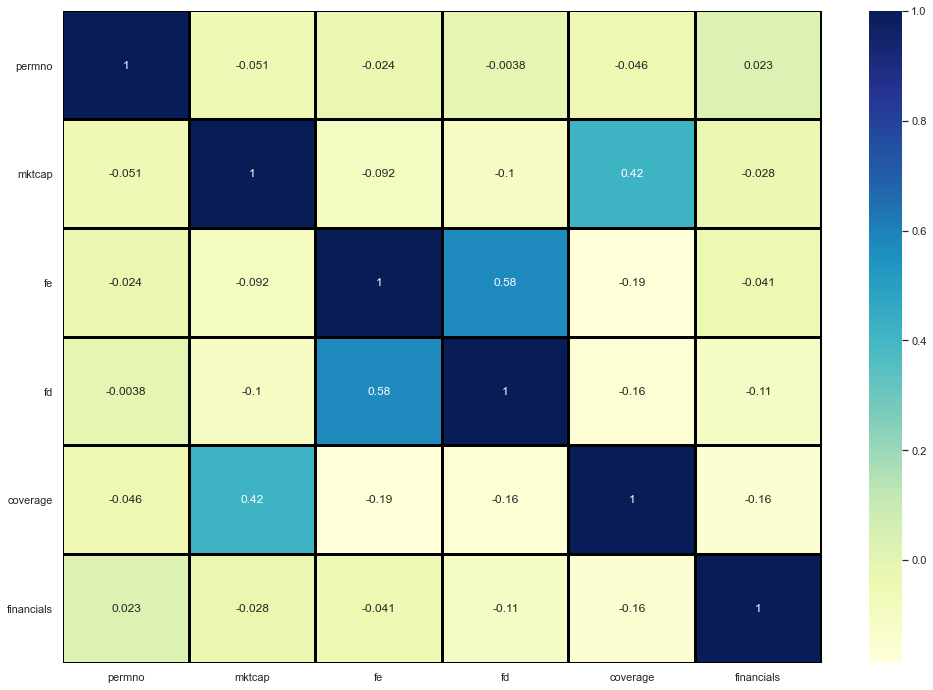

In [23]:
plt.subplots(figsize=(17,12))
sns.heatmap(round(df.corr(),4), annot = True, cmap="YlGnBu", linewidths=2, linecolor='black')
plt.yticks(rotation=0) 
plt.show()

#### d) Do a scatter plot of fe against coverage, and of fd against coverage. Label the axes in a meaningful way. Briefly comment on the two charts.

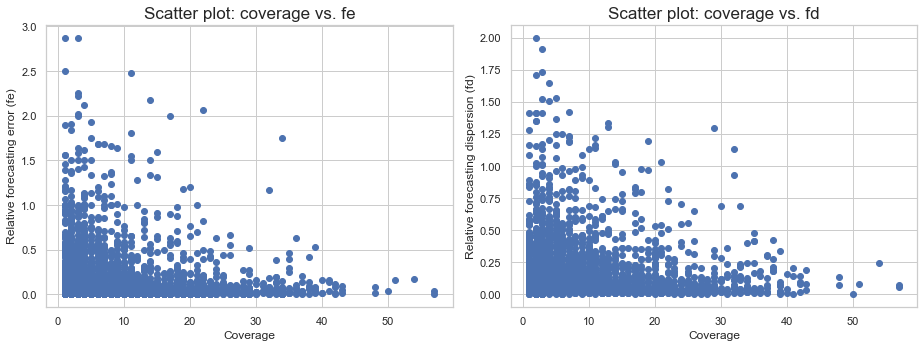

In [24]:
x1 = df['coverage']
x2 = df['coverage']
y1 = df['fe']
y2 = df['fd']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes[0].scatter(x1, y1)
axes[0].set_title('Scatter plot: coverage vs. fe', fontsize=17)
axes[0].set_xlabel('Coverage')
axes[0].set_ylabel('Relative forecasting error (fe)')
axes[1].scatter(x2, y2)
axes[1].set_title('Scatter plot: coverage vs. fd', fontsize=17)
axes[1].set_xlabel('Coverage')
axes[1].set_ylabel('Relative forecasting dispersion (fd)')
fig.tight_layout()

## 3. OLS: estimation and interpretation of the results (30%)

#### Pairplot for checking linearity of the regressors

<IPython.core.display.Javascript object>

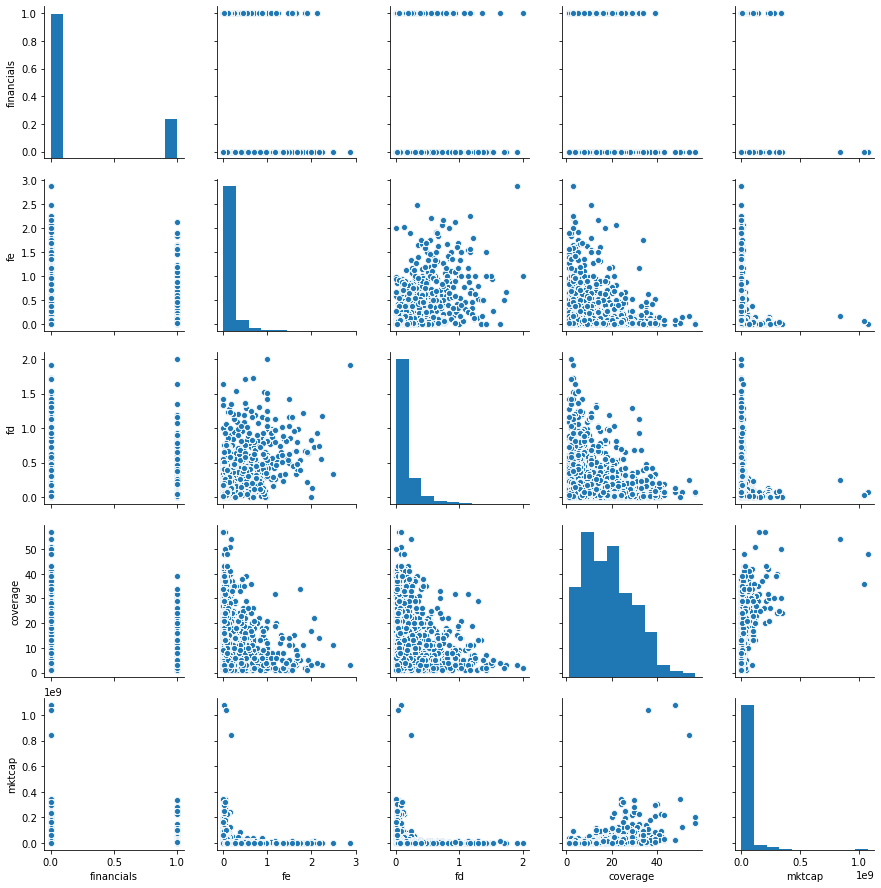

In [27]:
sns.pairplot(df.dropna(), vars = ['financials', 'fe', 'fd', 'coverage', 'mktcap'])

#### a) Run a regression of fe on financials and then of fe on financials and coverage. Interpret the coefficients and the R2 of both regressions.

In [25]:
# Regression_1:
model = ols('fe ~ C(financials)', data=df, missing = 'drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     fe   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.546
Date:                Sat, 26 Sep 2020   Prob (F-statistic):             0.0331
Time:                        16:30:50   Log-Likelihood:                -681.37
No. Observations:                2714   AIC:                             1367.
Df Residuals:                    2712   BIC:                             1379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2021      0

In [26]:
# Regression_2:
model = ols('fe ~ C(financials) + coverage', data=df, missing = 'drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     fe   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     56.94
Date:                Sat, 26 Sep 2020   Prob (F-statistic):           5.98e-25
Time:                        16:30:58   Log-Likelihood:                -627.81
No. Observations:                2714   AIC:                             1262.
Df Residuals:                    2711   BIC:                             1279.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2784      0

#### b) Re-run the above regression, where you additionally control for mktcap. How does the interpretation of the coefficient on coverage change?

In [27]:
# Regression_3:
model = ols('fe ~ C(financials) + coverage + mktcap', data=df, missing = 'drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     fe   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     37.76
Date:                Sat, 26 Sep 2020   Prob (F-statistic):           6.74e-24
Time:                        16:31:12   Log-Likelihood:                -625.48
No. Observations:                2713   AIC:                             1259.
Df Residuals:                    2709   BIC:                             1283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2766      0

#### c) Units of measurement:
- i) Scale the variable mktcap such that it gives the company market capitalization in billions of dollars. Re-run the last regression. How does the coefficient change? And the t-statistic? Explain.
- ii) Suppose that you are allowed to report only two decimals in your tables. Do you see a problem? What would you do?

In [28]:
df['mktcap'] = df['mktcap']/1000000000
model = ols('fe ~ C(financials) + coverage + mktcap', data=df, missing = 'drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     fe   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     37.76
Date:                Sat, 26 Sep 2020   Prob (F-statistic):           6.74e-24
Time:                        16:31:47   Log-Likelihood:                -625.48
No. Observations:                2713   AIC:                             1259.
Df Residuals:                    2709   BIC:                             1283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2766      0

#### d) Under which assumptions can we interpret the coefficient on coverage as measuring the causal effect of analysts' coverage on forecast accuracy? What threats to the identification of the causal effect do you see in this case?

In [ ]:
# Please refer to pdf

## 4. OLS: assumptions and mechanics (15%)

#### a) After running the previous regression of of fe on financials, coverage and mktcap, compute FORMULA. What is the result of the summation? Explain.

In [29]:
predicted_values = model.predict()
residual_values = model.resid
mean_predicted_values = [predicted_values.mean()]*len(predicted_values)
df_summation = pd.DataFrame(list(zip(predicted_values, residual_values, mean_predicted_values)))
df_summation.columns = ['predicted_values', 'residuals', 'y_hat_mean']
df_summation['result'] = df_summation['residuals']*(df_summation['predicted_values']-df_summation['y_hat_mean'])
result_summation = sum(df_summation['result'])

In [30]:
round(result_summation)

0

#### b) [Theory question] ---> see pdf file